In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

=================================================================================================================
# Extra Notes: Cross-Validation in Practice


##### D.Vidotto, Data Mining: JBI030 2019/2020


=================================================================================================================

In this notebook, we will see three examples that can help to better understand how to apply cross-validation in practical situations. Of course, the rationale behind these examples can be applied also to the holdout method. 

We will see examples of cross-validation applied in three common situations: 

1. how to perform grid search/random search with an estimator with more than one hyperparameter
1. how to perform cross-validation (grid search) with data pre-processing 
1. how to compare two estimators 

For such examples we are going to work with the `wine` dataset, provided with [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine). 


##  Dataset Exploration
We provide here a quick exploration of the training dataset. 

In [2]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
data = load_wine()
# Dataset size
X = pd.DataFrame(data.data)
X.columns = data.feature_names
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
X_train.shape, X_test.shape

((124, 13), (54, 13))

In [3]:
# Feature Names
X_train.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

In [4]:
# Classes
data.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

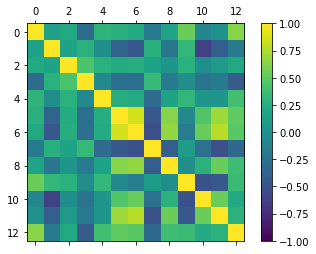

In [5]:
# Correlation matrix of features
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(X_train.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)

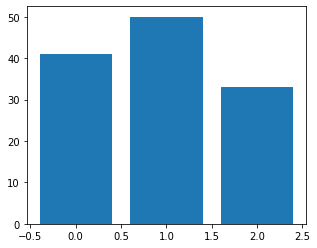

In [6]:
# Class distribution
plt.figure(figsize=(5,4))
plt.bar(np.unique(y_train),np.unique(y_train, return_counts=True)[1])
plt.show()

In [7]:
# Features are all continuous
X_train.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object

In [8]:
# No missing data are present 
X_train.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

## Example 1. Multi-parameter Classifier

**a. Two hyperparameters** Here, we will show a to tune a classifier when two hypeparameters must be tuned. In particular, we will work with the *support vector machines* (SVM) algorithm. At this point, it is not important yet to know how the algorithm works in practice: we will study it in detail in future lectures. For the moment, we just need to know that it is implemented by [the svm.SVC function](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) in `sklearn`, and that has two important hyperparameters that need to be tuned: C and gamma. Notice that both are real numbers, strictly positive. Once again, you don't need to know all the details yet. We just want to see how to perform tuning by modifying these two hyperparameters. We will do this with grid search first, and then with randomized search.

For *grid search*, we will set two grids (one for gamma, and one for C) and evaluate them with 5-fold-cv. We will use accuracy to measure the classifiers' performances. 

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.1, 1, 10, 20, 100, 1000, 5000], 
    'gamma': [1e-10, 1e-5,  1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 50]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
# Score on test data (default score: accuracy)
test_score = grid_search.score(X_test, y_test)
print("Cross-Validation score: {:.2f}".format(cv_score))
print("Best hyperparameter set: {}".format(best_params))
print("Test set score: {:.2f}".format(test_score))
print("=========")
print("Best estimator: {}".format(best_estimator))
print("=========")

Cross-Validation score: 0.94
Best hyperparameter set: {'C': 1000, 'gamma': 1e-05}
Test set score: 0.85
Best estimator: SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [10]:
results = pd.DataFrame(grid_search.cv_results_)
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002241,0.000287,0.001132,0.000154,0.001,1e-10,"{'C': 0.001, 'gamma': 1e-10}",0.4,0.4,0.4,0.4,0.416667,0.403333,0.006667,35
1,0.002032,0.000060,0.000978,0.000036,0.001,1e-05,"{'C': 0.001, 'gamma': 1e-05}",0.4,0.4,0.4,0.4,0.416667,0.403333,0.006667,35
2,0.002058,0.000141,0.001039,0.000102,0.001,0.0001,"{'C': 0.001, 'gamma': 0.0001}",0.4,0.4,0.4,0.4,0.416667,0.403333,0.006667,35
3,0.002168,0.000282,0.001071,0.000216,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.4,0.4,0.4,0.4,0.416667,0.403333,0.006667,35
4,0.002043,0.000046,0.000985,0.000120,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.4,0.4,0.4,0.4,0.416667,0.403333,0.006667,35


With two hyperparameters (two dimensions), it is better to visualize the results in a heatmap. 

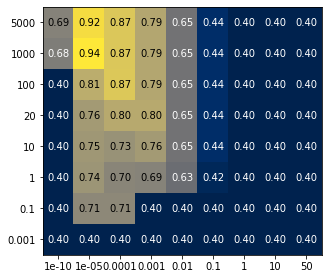

In [11]:
scores = np.array(results["mean_test_score"]).reshape(len(param_grid['C']), len(param_grid['gamma']))

# Function that plots heatmap results
# Revised version of the mglearn function (https://github.com/amueller/mglearn/blob/master/mglearn/tools.py):
def draw_heatmap(values, xticklabels, yticklabels,
                 xlabel, ylabel,
                 fmt="%0.2f", cmap = 'cividis', 
                 vmin=None, vmax=None,
                 f_size=(5,5)):
    plt.figure(figsize=f_size)
    ax = plt.gca()    
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    plt.show()

draw_heatmap(scores, xticklabels = param_grid['gamma'], 
             yticklabels = param_grid['C'],
             xlabel="gamma", ylabel="C")

We now try to perform randomized search, to compare the results. We will use two exponential distributions, Exp(0.001) for gamma and Exp(1000) for C. Let's draw 100 samples, with 5-fold-cross-validation. 

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
param_grid = {
    'C': stats.expon(scale=1000), 
    'gamma': stats.expon(scale=0.001)
}

random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid, 
                                   n_iter=100, cv=5, random_state=1)
random_search.fit(X_train, y_train)
cv_score = random_search.best_score_
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_
# Score on test data (default score: accuracy)
test_score = random_search.score(X_test, y_test)
print("Cross-Validation score: {:.2f}".format(cv_score))
print("Best hyperparameter set: {}".format(best_params))
print("Test set score: {:.2f}".format(test_score))
print("=========")
print("Best estimator: {}".format(best_estimator))
print("=========")

Cross-Validation score: 0.93
Best hyperparameter set: {'C': 823.3247048496826, 'gamma': 1.8823342112877367e-05}
Test set score: 0.85
Best estimator: SVC(C=823.3247048496826, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=1.8823342112877367e-05, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)


In [13]:
results = pd.DataFrame(random_search.cv_results_).sort_values(["mean_test_score","param_gamma","param_C"], 
                                                             ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
66,0.002906,0.000315,0.001019,0.000179,823.325,1.88233e-05,"{'C': 823.3247048496826, 'gamma': 1.8823342112...",0.92,0.96,1.00,0.92,0.875000,0.935000,0.042190,1
74,0.002414,0.000471,0.000723,0.000040,820.338,1.26355e-05,"{'C': 820.3375362446026, 'gamma': 1.2635472582...",0.92,0.96,1.00,0.88,0.875000,0.927000,0.047707,2
27,0.002525,0.000308,0.000786,0.000140,676.434,5.48391e-05,"{'C': 676.433946568558, 'gamma': 5.48390944891...",0.84,0.96,0.96,0.84,0.875000,0.895000,0.054589,3
82,0.001807,0.000146,0.000709,0.000022,170.541,1.87509e-05,"{'C': 170.5408956566086, 'gamma': 1.8750906769...",0.92,0.96,0.88,0.84,0.875000,0.895000,0.041231,3
13,0.001881,0.000371,0.000779,0.000087,88.8795,3.98379e-05,"{'C': 88.87953331090478, 'gamma': 3.9837878122...",0.88,0.92,0.88,0.84,0.916667,0.887333,0.029242,5


Let's plot the accuracies observed for the 30 best models: 

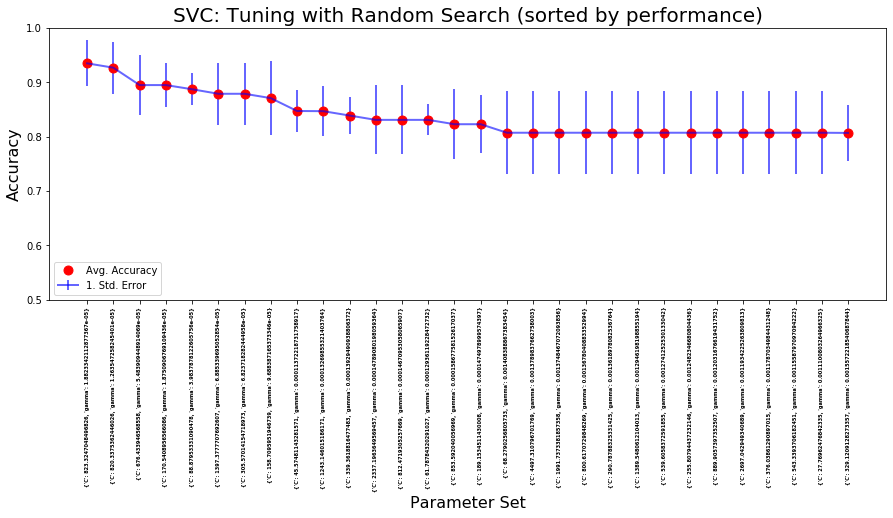

In [14]:
# Plot accuracy of 30 best models
best = 30
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ax.tick_params(axis='x', rotation=90)
plt.errorbar(range(best), results.iloc[0:best]["mean_test_score"], 
             yerr=results.iloc[0:best]["std_test_score"], c="blue", label="1. Std. Error", alpha=0.6,
            linewidth=2)
plt.plot(range(best), results.iloc[0:best]["mean_test_score"], 'ro', label="Avg. Accuracy", markersize=9)
plt.xticks(range(best), labels=results.iloc[0:best]["params"], 
          fontweight='bold', fontsize=5)
plt.xlabel('Parameter Set', fontsize=16)
t = plt.title('SVC: Tuning with Random Search (sorted by performance)', fontsize=20)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.5,1)
plt.legend(loc=3)
plt.show()

**b. Three hyperparameters**. We now tune the same model, the [SVC classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), with a third hyperparameter. In particular, the `kernel` argument takes a string as input. Here, we will try the `linear` and `rbf` options. When `kernel=linear` the parameter gamma is meaningless (as you will find out in the lecture dedicated to SVM), so it would be a waste of time to iterate (in Grid Search) over different values of gamma when kernel is linear. However, gamma is useful when `kernel=rbf`. Fortunately, scikit-learn allows us to use a *list of dictionaries*; in this case, each dictionary is seen as an independent grid of values. We will show an example with GridSearchCV(), but the principle is the same for RandomizedSearchCV() (where a dictionary is sampled first, and then the parameters specified by the dictionary).  

In [15]:
param_grid = [
    {'kernel':['rbf'],
    'C': [0.001, 0.1, 1, 10, 20, 100, 1000, 5000], 
    'gamma': [1e-10, 1e-5,  1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 50]
    }, 
    {'kernel':['linear'],     
    'C': [0.001, 0.1, 1, 10, 20, 100, 1000, 5000]
    }
]


grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
test_score = grid_search.score(X_test, y_test)
print("Cross-Validation score: {:.2f}".format(cv_score))
print("Best hyperparameter set: {}".format(best_params))
print("Test set score: {:.2f}".format(test_score))
print("=========")
print("Best estimator: {}".format(best_estimator))
print("=========")

Cross-Validation score: 0.96
Best hyperparameter set: {'C': 1, 'kernel': 'linear'}
Test set score: 0.93
Best estimator: SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


It appears that the best model has a linear kernel. Let's visualize the cross-validation results: 

In [16]:
results = pd.DataFrame(grid_search.cv_results_).sort_values(["mean_test_score"], 
                                                             ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
74,0.048965,0.017800,0.001165,0.000267,1,NaN,linear,"{'C': 1, 'kernel': 'linear'}",0.92,0.92,1.0,1.0,0.958333,0.959667,0.035783,1
79,0.067858,0.043964,0.001225,0.000505,5000,NaN,linear,"{'C': 5000, 'kernel': 'linear'}",0.88,0.92,1.0,1.0,0.958333,0.951667,0.046595,2
78,0.067920,0.038915,0.001401,0.000458,1000,NaN,linear,"{'C': 1000, 'kernel': 'linear'}",0.88,0.92,1.0,1.0,0.958333,0.951667,0.046595,2
77,0.064054,0.036515,0.001120,0.000237,100,NaN,linear,"{'C': 100, 'kernel': 'linear'}",0.88,0.92,1.0,1.0,0.958333,0.951667,0.046595,2
76,0.070535,0.043269,0.001053,0.000138,20,NaN,linear,"{'C': 20, 'kernel': 'linear'}",0.88,0.92,1.0,1.0,0.958333,0.951667,0.046595,2


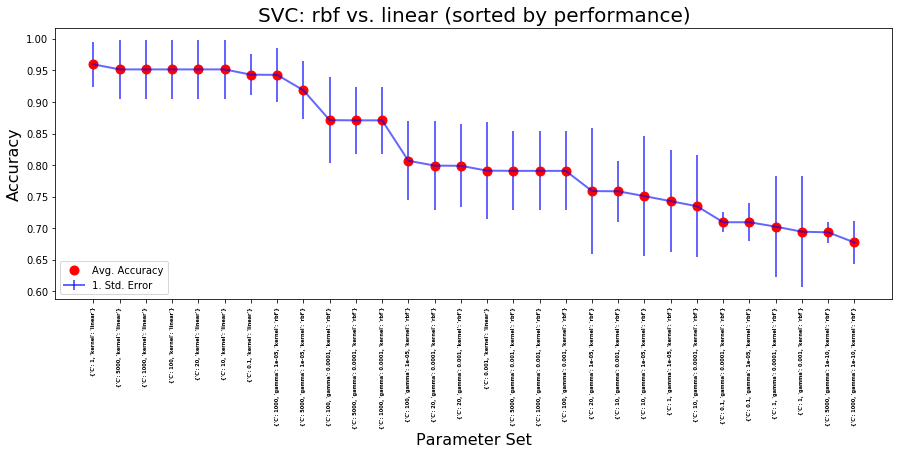

In [17]:
# Plot accuracy of 30 best models
best = 30
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ax.tick_params(axis='x', rotation=90)
plt.errorbar(range(best), results.iloc[0:best]["mean_test_score"], 
             yerr=results.iloc[0:best]["std_test_score"], c="blue", label="1. Std. Error", alpha=0.6,
            linewidth=2)
plt.plot(range(best), results.iloc[0:best]["mean_test_score"], 'ro', label="Avg. Accuracy", markersize=9)
plt.xticks(range(best), labels=results.iloc[0:best]["params"], 
          fontweight='bold', fontsize=5)
plt.xlabel('Parameter Set', fontsize=16)
t = plt.title('SVC: rbf vs. linear (sorted by performance)', fontsize=20)
plt.ylabel("Accuracy",fontsize=16)



plt.legend(loc=3)
plt.show()

As we can see from the plot, the 7 best models all have a linear kernel. 

## Example 2. Cross-Validation with data pre-processing
As remarked in the cross-validation section of the Model Selection notebook, it is important to pre-process the data by estimating the preprocessing parameters within each iteration of cross-validation (or, more in general, with the training set) and transform each validation set with those parameters. If not, you can incur into what is called 'information leakage': the validation data and training data are preprocessed together, and too optimistic results could be observed. You can see a detailed example in section 7.10 (pag. 242) of [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf). 

Here, we are going to see how to correctly perform cross-validation with pre-processing. In particular, we will: 

* check which one is the best data scaling method between `MinMaxScaler` (normalization) or `StandardScaler` (standardization)
* try SelectKBest() with varying number of best features to select
* tune `k` of k-nearest-neighbors

You can review scaling and feature selection in the data preprocessing notebook. Pipelines (also introduced in the data preprocessing lecture) can be given as input not only scikit-learn transformers (that is, estimators that can transform data) but also regressors and classifiers (with the only requirement that regressors/classifiers, having a predict method, must be the last elements of the pipeline). We will continue to work with the `wine` dataset introduced above. We evaluate knn with $k \in \{1, 5, 10, 20, 50\}$ in combination with `SelectKBest` for feature selection. For the latter, we compare the values given by the 1, 2, 5 and 10 best features selected with the `f_classif` measure. 

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
pipe = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("selector", SelectKBest(score_func=f_classif)),  
    ("knn", KNeighborsClassifier())
])

# For the hyperparameters, we need to give the object names specified in the pipeline to the parameter grid, 
# followed by "__" and the name of their parameters; 
# For transformers and estimators, we simply use the name given in the Pipeline (e.g., 'scaler')
param_grid = {
    'scaler' : [MinMaxScaler(), StandardScaler()],
    'selector__k' : [1, 2, 5, 10], 
    'knn__n_neighbors' : [1, 5, 10, 20, 50]
}

# We can now feed GridSearchCV with the pipeline and parameter grid created above
grid_estimator = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid_estimator.fit(X_train, y_train)

cv_score = grid_estimator.best_score_
best_params = grid_estimator.best_params_
best_estimator = grid_estimator.best_estimator_
# Importantly, all the preprocessing steps used with the best estimator
# are automatically incorporated when predicting and evaluating the scores
# in the test set. This means the test set will be automatically rescaled
# and reduced to the best feature set found by GridSearchCV
test_score = grid_estimator.score(X_test, y_test)
print("Cross-Validation score: {:.2f}".format(cv_score))
print("Best hyperparameter set: {}".format(best_params))
print("Test set score: {:.2f}".format(test_score))
print("=========")
print("Best estimator: {}".format(best_estimator))
print("=========")

Cross-Validation score: 0.98
Best hyperparameter set: {'knn__n_neighbors': 5, 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)), 'selector__k': 10}
Test set score: 0.96
Best estimator: Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('selector',
                 SelectKBest(k=10,
                             score_func=<function f_classif at 0x7feec7ec4040>)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)


Best cross-validation performance was achieved with $k=5$ neighbors, in combination with 10 features selected with the `f_classif` measure and MinMaxScaler. Let's visualize the results. First, the pipeline steps: 

In [19]:
pipe.named_steps

{'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'selector': SelectKBest(k=10, score_func=<function f_classif at 0x7feec7ec4040>),
 'knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='uniform')}

Then, more detailed results: 

In [20]:
results = pd.DataFrame(grid_estimator.cv_results_).sort_values(["mean_test_score"], 
                                                             ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_scaler,param_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.003148,0.000503,0.002156,0.000117,5,"MinMaxScaler(copy=True, feature_range=(0, 1))",10,"{'knn__n_neighbors': 5, 'scaler': MinMaxScaler...",0.92,1.00,0.96,1.00,1.000000,0.976000,0.032000,1
2,0.003264,0.000423,0.002267,0.000227,1,"MinMaxScaler(copy=True, feature_range=(0, 1))",5,"{'knn__n_neighbors': 1, 'scaler': MinMaxScaler...",0.96,1.00,1.00,0.96,0.958333,0.975667,0.019877,2
6,0.003473,0.000388,0.002286,0.000269,1,"StandardScaler(copy=True, with_mean=True, with...",5,"{'knn__n_neighbors': 1, 'scaler': StandardScal...",0.96,1.00,1.00,0.96,0.958333,0.975667,0.019877,2
14,0.002747,0.000142,0.001834,0.000167,5,"StandardScaler(copy=True, with_mean=True, with...",5,"{'knn__n_neighbors': 5, 'scaler': StandardScal...",0.96,1.00,1.00,0.96,0.958333,0.975667,0.019877,2
15,0.002673,0.000176,0.001768,0.000051,5,"StandardScaler(copy=True, with_mean=True, with...",10,"{'knn__n_neighbors': 5, 'scaler': StandardScal...",0.92,0.96,0.96,1.00,1.000000,0.968000,0.029933,5


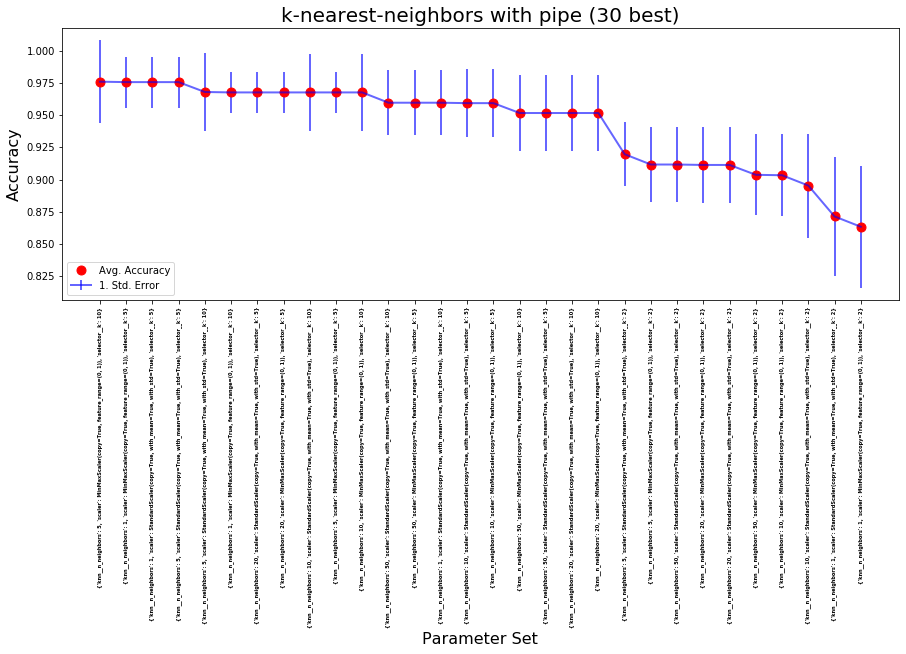

In [21]:
# Plot accuracy of 30 best models
best = 30
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ax.tick_params(axis='x', rotation=90)
plt.errorbar(range(best), results.iloc[0:best]["mean_test_score"], 
             yerr=results.iloc[0:best]["std_test_score"], c="blue", label="1. Std. Error", alpha=0.6,
            linewidth=2)
plt.plot(range(best), results.iloc[0:best]["mean_test_score"], 'ro', label="Avg. Accuracy", markersize=9)
plt.xticks(range(best), labels=results.iloc[0:best]["params"], 
          fontweight='bold', fontsize=5)
plt.xlabel('Parameter Set', fontsize=16)
t = plt.title('k-nearest-neighbors with pipe (30 best)', fontsize=20)
# plt.ylim(0.8, 1.1)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc=3)
plt.show()

We can assess the scores given by the `SelectKBest` (and thus recover which ones are the 10 best features in this case): 

In [22]:
np.c_[X_train.columns,grid_estimator.best_estimator_.named_steps['selector'].scores_]

array([['alcohol', 102.32228832779859],
       ['malic_acid', 33.85648766144196],
       ['ash', 6.211649892148904],
       ['alcalinity_of_ash', 23.33584888185784],
       ['magnesium', 10.74398401241553],
       ['total_phenols', 68.07561257010346],
       ['flavanoids', 157.92353523922299],
       ['nonflavanoid_phenols', 18.704324148866938],
       ['proanthocyanins', 24.649212873876277],
       ['color_intensity', 90.60624252524745],
       ['hue', 62.320224277506114],
       ['od280/od315_of_diluted_wines', 121.72898168300513],
       ['proline', 150.5191133826299]], dtype=object)

What you have just seen is the proper way to chain preprocessing steps and model tuning together. There are many other useful functions and tricks that you can use (for instance, take a look at the [make_pipeline() function](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html). You can learn more about chaining and composition in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/compose.html). 

**Notes and Other Remarks**: in case of class imbalance, if you decide to use oversampling methods (as for instance SMOTE) in the preprocessing stage, you should use the pipeline [provided with `imblearn`](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.pipeline.Pipeline.html). Furthermore, it is important that you also include missing data imputation (or other general treatments) in the pipelines as done in this last example. In general, it is possible to chain as many steps as it is wished, with the only requirement that the last step contains a `predict` method (that is, it is an estimator). 

## Example 3. Comparing Estimators (with pipelines) 
As a last example, we are going to compare three methods: 

* LogisticRegression in which the `C` parameter is tuned, and for which we are going to evaluate its performance with different ways of scaling the data, prior to model training: no scaling, standardization (with StandardScaler), and normalization (with MinMaxScaler) 
* k-nearest-neighbors, for which we will tune tha parameter k (without data scaling)

Because both k-nearest-neighbors and one instance of logistic regression do not use scaling, we can set the corresponding step in the pipeline with `None`. 

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('preprocessing', StandardScaler()), 
    ('classifier', KNeighborsClassifier())
])

# We specify a large value of max_iter for LogisticRegression, otherwise it won't converge
param_grid = [
    {'classifier': [KNeighborsClassifier()], 
    'preprocessing': [None], 
    'classifier__n_neighbors' : [1, 2, 5, 10, 50],
    },
    {'classifier': [LogisticRegression(max_iter=1e+05)], 
    'preprocessing' : [StandardScaler(), MinMaxScaler(), None], 
    'classifier__C' : [0.001, 0.01, 0.1, 0.5, 1, 10, 20],
    }
]


grid_estimator = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid_estimator.fit(X_train, y_train)

cv_score = grid_estimator.best_score_
best_params = grid_estimator.best_params_
best_estimator = grid_estimator.best_estimator_
print("Cross-Validation score: {:.2f}".format(cv_score))
print("Best hyperparameter set: {}".format(best_params))
print("=========")
print("Best estimator: {}".format(best_estimator))
print("=========")

Cross-Validation score: 0.98
Best hyperparameter set: {'classifier': LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000.0,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 10, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}
Best estimator: Pipeline(memory=None,
         steps=[('preprocessing',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100000.0,
                                    multi_class='auto', n_jobs=None,
                                    

The best picked classifier is logistic regression, with C=10 and in combination with StandardScaler. Let's see if there is some nearest-neighbor model among the best performing ones: 

In [24]:
results = pd.DataFrame(grid_estimator.cv_results_).sort_values(["mean_test_score"], 
                                                             ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_neighbors,param_preprocessing,param_classifier__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,0.009450,0.000942,0.001016,0.000151,"LogisticRegression(C=10, class_weight=None, du...",NaN,"StandardScaler(copy=True, with_mean=True, with...",20,"{'classifier': LogisticRegression(C=10, class_...",0.96,0.96,1.00,1.0,1.0,0.984,0.019596,1
20,0.009375,0.000827,0.001087,0.000240,"LogisticRegression(C=10, class_weight=None, du...",NaN,"StandardScaler(copy=True, with_mean=True, with...",10,"{'classifier': LogisticRegression(C=10, class_...",0.96,0.96,1.00,1.0,1.0,0.984,0.019596,1
14,0.007263,0.000566,0.000955,0.000187,"LogisticRegression(C=10, class_weight=None, du...",NaN,"StandardScaler(copy=True, with_mean=True, with...",0.5,"{'classifier': LogisticRegression(C=10, class_...",0.92,0.96,1.00,1.0,1.0,0.976,0.032000,3
24,0.012439,0.001344,0.001222,0.000365,"LogisticRegression(C=10, class_weight=None, du...",NaN,"MinMaxScaler(copy=True, feature_range=(0, 1))",20,"{'classifier': LogisticRegression(C=10, class_...",0.92,0.96,1.00,1.0,1.0,0.976,0.032000,3
18,0.007711,0.000491,0.000799,0.000066,"LogisticRegression(C=10, class_weight=None, du...",NaN,"MinMaxScaler(copy=True, feature_range=(0, 1))",1,"{'classifier': LogisticRegression(C=10, class_...",0.92,1.00,0.96,1.0,1.0,0.976,0.032000,3


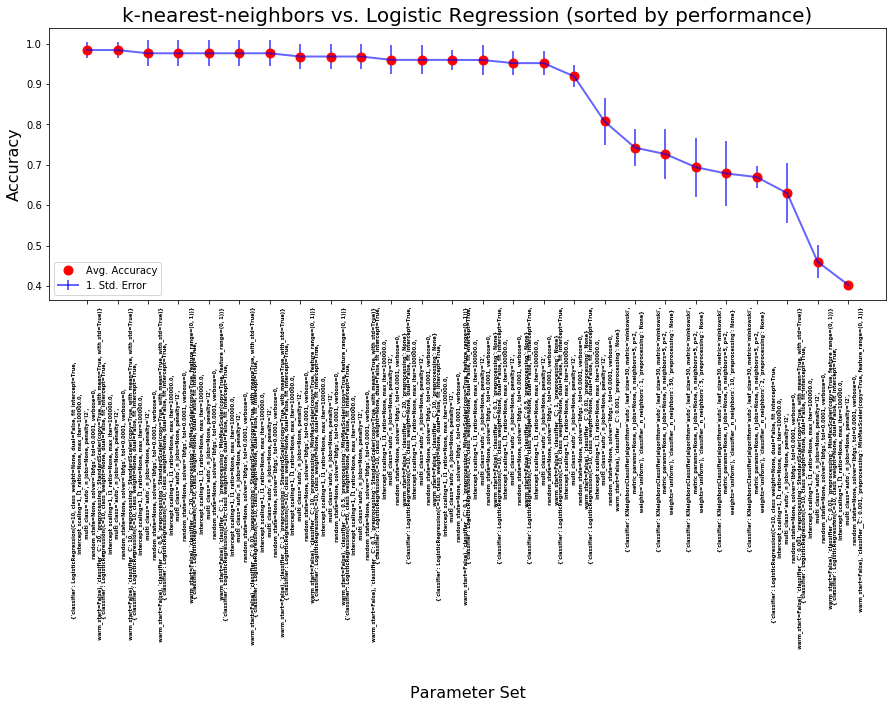

In [25]:
# Plot accuracy of 10 best models
best = 26
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ax.tick_params(axis='x', rotation=90)
plt.errorbar(range(best), results.iloc[0:best]["mean_test_score"], 
             yerr=results.iloc[0:best]["std_test_score"], c="blue", label="1. Std. Error", alpha=0.6,
            linewidth=2)
plt.plot(range(best), results.iloc[0:best]["mean_test_score"], 
         "ro", label="Avg. Accuracy", markersize=9)
plt.xticks(range(best), labels=results.iloc[0:best]["params"], 
          fontweight='bold', fontsize=5)
plt.xlabel('Parameter Set', fontsize=16)
plt.title('k-nearest-neighbors vs. Logistic Regression (sorted by performance)', fontsize=20)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc=3)
plt.show()

Thus, it appears that LogistiRegression models with standardized data are the best performing ones. Setting logistic regression with $C=10$ and $C=20$ led to exactly the same results, while the model with $C=0.5$ is only slightly worse than the best-performing model. All knn models perform badly, and the best one among those is the one with $k=1$. Are the differences between these models statistically significant? We will conduct a [McNemar test](https://en.wikipedia.org/wiki/McNemar%27s_test) to compare the performance of logistic regression with standard scalers, and C=0.5 or C=10, as well as k-nearest-neighbors with k=1 (we prefer logistic regression with C=10 over the one with C=20, as C=10 leads to a simpler model). To perform the test, we are going to use the functions implemented in the [mlxtend package](https://rasbt.github.io/mlxtend/user_guide/evaluate/mcnemar/#mcnemars-test).

In [26]:
from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import mcnemar_table
from sklearn.model_selection import cross_val_predict

log_reg_chosen_1 = Pipeline([
    ('preprocessing', StandardScaler()), 
    ('classifier', LogisticRegression(max_iter=1e+05, C=10))
])

log_reg_chosen_2 = Pipeline([
    ('preprocessing', StandardScaler()), 
    ('classifier', LogisticRegression(max_iter=1e+05, C=0.5))
])

knn_chosen = KNeighborsClassifier(n_neighbors=1)

# Obtain cross-validation predictions for the three classifiers
knn_predictions = cross_val_predict(knn_chosen, X_train, y_train, cv=5)
log_reg_predictions_1 = cross_val_predict(log_reg_chosen_1, X_train, y_train, cv=5)
log_reg_predictions_2 = cross_val_predict(log_reg_chosen_2, X_train, y_train, cv=5)

# Create mcnemar table for logisti regression 1 vs. logistic regression 2
tb_log1_vs_log2 = mcnemar_table(y_target=y_train, 
                   y_model1=log_reg_predictions_1, 
                   y_model2=log_reg_predictions_2)
# Perform the test
chi2, p = mcnemar(ary=tb_log1_vs_log2, exact=True)
print('chi-squared:', chi2)
print('p-value:', p)

chi-squared: 0
p-value: 1.0


The two models do not to lead to statistically different results (p-value > 0.05); we will choose the simpler model to continue (the one with C=0.5) (*note*: this choice is arbitrary. You might prefer the cross-validation accuracy over simplicity, and continue with the logistic regression model with C=10 as long as the choice is motivated). Let's now compare the predictions of the selected logistic regression model with those of the `knn` model:  

In [27]:
# Create mcnemar table for logistic regression vs. knn
tb_log2_vs_knn = mcnemar_table(y_target=y_train, 
                   y_model1=log_reg_predictions_2, 
                   y_model2=knn_predictions)
# Perform the test
chi2_b, p_b = mcnemar(ary=tb_log2_vs_knn, exact=True)
print('chi-squared:', chi2_b)
print('p-value:{:.2f}'.format(p_b))

chi-squared: 0
p-value:0.00


Now results are strongly in favor of the logistic regression model: the p-value is smaller than 0, which means the two classifiers lead to statistically different results. 

Another way to perform a test is with the paired two-sample t-test (implementable with [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html)). Even though it can lead to too optimistic results, it can be a way to statistically compare measures such as $f_1$ scores across various cross-validation folds. In addition, you can also split the data using `KFold` or `StratifiedKFold` with the option `shuffle=True`, and setting a desired number of iterations in order to increase the resampling size and (hopefully) obtain more robust results. If you decide to do so, remember to use the results of `(Stratified)KFold` as input argument `cv` in `cross_val_predict`, and subsequently perform the tests as done above. 

Thus, our 'winning' and final model is LogisticRegression, in combination with data standardization (StandardScaler) and hyperparameter C=0.5. Last, we see the final accuracy on the test data: 

In [28]:
pipe.fit(X_train, y_train)
test_score = pipe.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_score))

Test set accuracy: 0.93


How confident are we about this estimate? We can find it out with a 95% confidence interval: 

In [29]:
from scipy import stats
y_test_pred = pipe.predict(X_test)
stats.t.interval(0.95, len(y_test_pred)-1,
                loc=test_score, 
                scale=stats.sem(y_test_pred==y_test))

(0.8537721212221421, 0.9980797306297098)

**Final Remark**. Since your pipelines can potentially get to chain many operations together, it is a good idea to use the `n_jobs` parameter of `GridSearchCV`, which allows for parallelization and speeds up computations. Setting it to -1 will exploit all the cores present in your processor. 

**Exercises**: 
* **(a)** Is the superior performance of LogisticRegression over knn due to the model itself or to the data scaling? Try adding the two data scaling operations (standardization, normalization)  to the grid of knn in the last example and compare the new results
* **(b)** try to include the SelectKBest() feature selector of example 3.2 in the pipelines of example 3.3, in this way: either LogisticRegression or k-nearest-neighbors can perform features selection, choosing among 1, 2, 5, and 10 features, or they can both discard such operations. When feature selection is implemented, you should use the `f_classif` measure. Insert SelectKBest as last pre-processing technique, before the estimators
* **(c)**  On top of the steps added in (b), add an outlier detection method (you can choose the specific method and contamination ratio) for both logistic regression and k-nearest-neighbors (outlier removal must come *before* any data rescaling steps, in order to preserve the rescaling)
* **(d)** Among the steps of the pipeline created in (c), replace the feature selection step (for both logistic regression and knn) with a PCA step, in which you try to retain 80%, 90%, and 95% of the total variance. PCA should come as last prepocessing step, before the estimators